In [1]:
import pickle
target_dict = None
with open("./data/pickle/target_dict.bin", "rb") as f:
    target_dict = pickle.load(f)

In [2]:
targets = target_dict.values()
target_lengths = list()

for target in targets:
    target_lengths.append(len(target.split()))

In [3]:
import pandas as pd

target_lengths = pd.DataFrame({"length" : target_lengths})
target_lengths.head()

,length
0,16
1,17
2,20
3,23
4,104


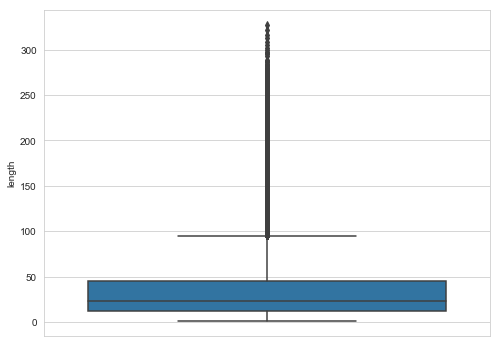

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")
%matplotlib inline

plt.figure(figsize=(8,6))
sns.boxplot(y="length",data=target_lengths)
plt.show()

In [18]:
length_group = []
length_group.append(target_lengths[(target_lengths["length"] > 0) & (target_lengths["length"] < 50)].count())
length_group.append(target_lengths[(target_lengths["length"] > 50) & (target_lengths["length"] < 100)].count())
length_group.append(target_lengths[(target_lengths["length"] > 100) & (target_lengths["length"] < 150)].count())
length_group.append(target_lengths[(target_lengths["length"] > 150) & (target_lengths["length"] < 200)].count())
length_group.append(target_lengths[(target_lengths["length"] > 200) & (target_lengths["length"] < 250)].count())
length_group.append(target_lengths[(target_lengths["length"] > 250) & (target_lengths["length"] < 300)].count())
length_group.append(target_lengths[(target_lengths["length"] > 300) & (target_lengths["length"] < 350)].count())

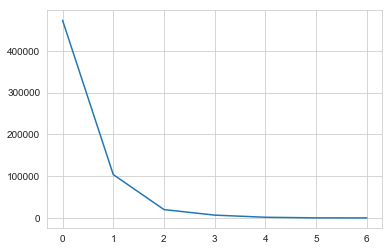

In [20]:
plt.plot(length_group)
plt.show()

In [21]:
length_group[6]

length    7
dtype: int64

In [22]:
length_group[5]

length    142
dtype: int64

In [4]:
import queue
import torch.nn as nn
import torch.optim as optim
import random
import torch
import time
import os
from utils.define import *
from utils.dataset import split_dataset
from utils.hparams import HyperParams
from utils.loader import BaseDataLoader, MultiLoader
from utils.load import load_targets, load_data_list, load_pickle
from utils.save import save_epoch_result
from models.speller import Speller
from models.listener import Listener
from models.listenAttendSpell import ListenAttendSpell
from train.loss import LabelSmoothingLoss
from train.evaluator import evaluate
from train.trainer import train


if __name__ == '__main__':
    hparams = HyperParams()
    hparams.logger_hparams()

    random.seed(hparams.seed)
    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed_all(hparams.seed)
    cuda = hparams.use_cuda and torch.cuda.is_available()
    device = torch.device('cuda' if cuda else 'cpu')

    listener = Listener(
        feat_size = 128,
        hidden_size = hparams.hidden_size,
        dropout_p = hparams.dropout,
        layer_size = hparams.listener_layer_size,
        bidirectional = hparams.use_bidirectional,
        rnn_cell = 'gru',
        use_pyramidal = hparams.use_pyramidal
    )
    speller = Speller(
        vocab_size = len(char2id),
        max_len = hparams.max_len,
        k = 8,
        hidden_size = hparams.hidden_size << (1 if hparams.use_bidirectional else 0),
        sos_id = SOS_TOKEN,
        eos_id = EOS_TOKEN,
        layer_size = hparams.speller_layer_size,
        score_function = hparams.score_function,
        rnn_cell = 'gru',
        dropout_p = hparams.dropout,
        use_attention = hparams.use_attention,
        device = device
    )
    model = ListenAttendSpell(listener, speller, use_pyramidal = hparams.use_pyramidal)

[2020-03-04 00:04:01,430 hparams.py:100 - logger_hparams()] use_bidirectional : True
[2020-03-04 00:04:01,433 hparams.py:101 - logger_hparams()] use_attention : True
[2020-03-04 00:04:01,435 hparams.py:102 - logger_hparams()] use_pickle : False
[2020-03-04 00:04:01,437 hparams.py:103 - logger_hparams()] use_augment : True
[2020-03-04 00:04:01,439 hparams.py:104 - logger_hparams()] use_pyramidal : True
[2020-03-04 00:04:01,440 hparams.py:105 - logger_hparams()] attention : self
[2020-03-04 00:04:01,442 hparams.py:106 - logger_hparams()] augment_ratio : 1.00
[2020-03-04 00:04:01,444 hparams.py:107 - logger_hparams()] input_reverse : True
[2020-03-04 00:04:01,446 hparams.py:108 - logger_hparams()] hidden_size : 256
[2020-03-04 00:04:01,448 hparams.py:109 - logger_hparams()] listener_layer_size : 6
[2020-03-04 00:04:01,450 hparams.py:110 - logger_hparams()] speller_layer_size : 3
[2020-03-04 00:04:01,451 hparams.py:111 - logger_hparams()] dropout : 0.50
[2020-03-04 00:04:01,453 hparams.py:

In [5]:
model

ListenAttendSpell(
  (listener): Listener(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Hardtanh(min_val=0, max_val=20, inplace=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Hardtanh(min_val=0, max_val=20, inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): Hardtanh(min_val=0, max_val=20, inplace=True)
      (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): Hardtanh(min_val=0, max_val=20, inplace=True)
      (12): BatchNorm2d(128, eps=